In [59]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

ide_plot() #plot for github dark theme

In [60]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [61]:
reduced = PCA(n_components=10).fit_transform(np.array([*dataset.values, *(ReduceModel.dataset.cpu().detach().numpy())]))

In [62]:
main_reduced = reduced[:len(dataset),:]
qmof_reduced = reduced[len(dataset):, :]

In [63]:
main_reduced.shape, qmof_reduced.shape

((102, 10), (7463, 10))

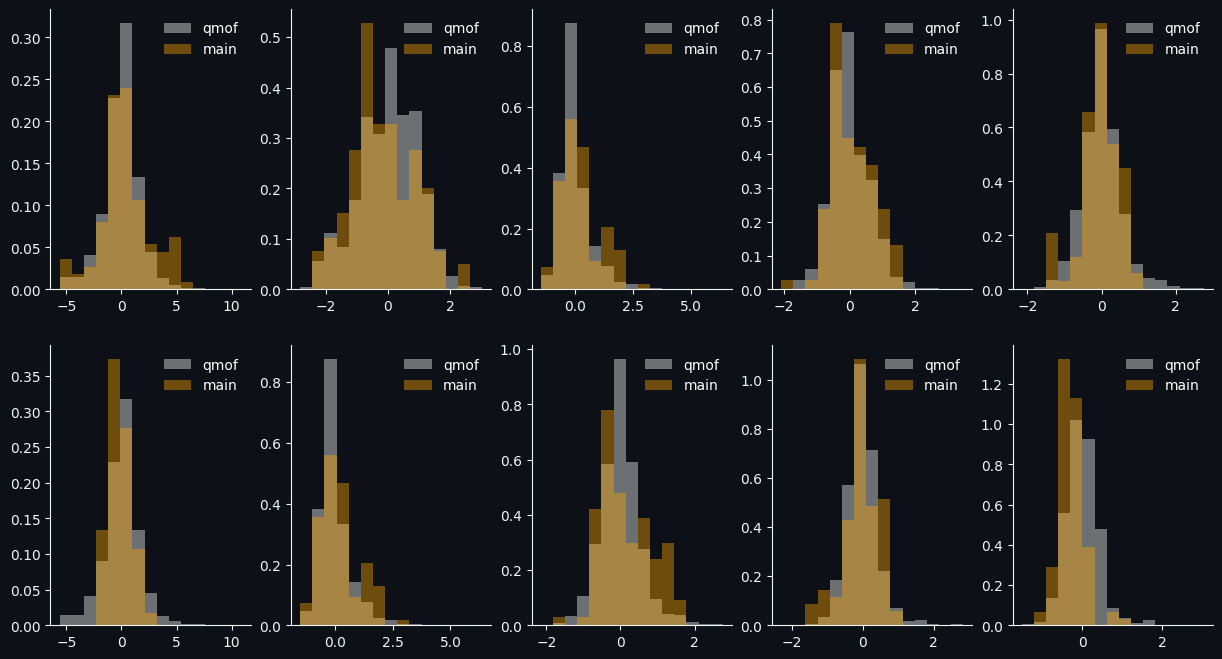

In [64]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced[:, j+i*j], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,j].hist(main_reduced[:, i+j], density=True, bins=bins, alpha=0.4, label="main", color='orange')
        axes[i,j].legend()
        


In [65]:
from sklearn.preprocessing import Normalizer


def plot_2d(x1, y1, name):
    x1 = Normalizer().transform(x1)
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

def plot_2d_proba(x1, y1_proba, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[:, 0], X_t[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[:, 0], X_p[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

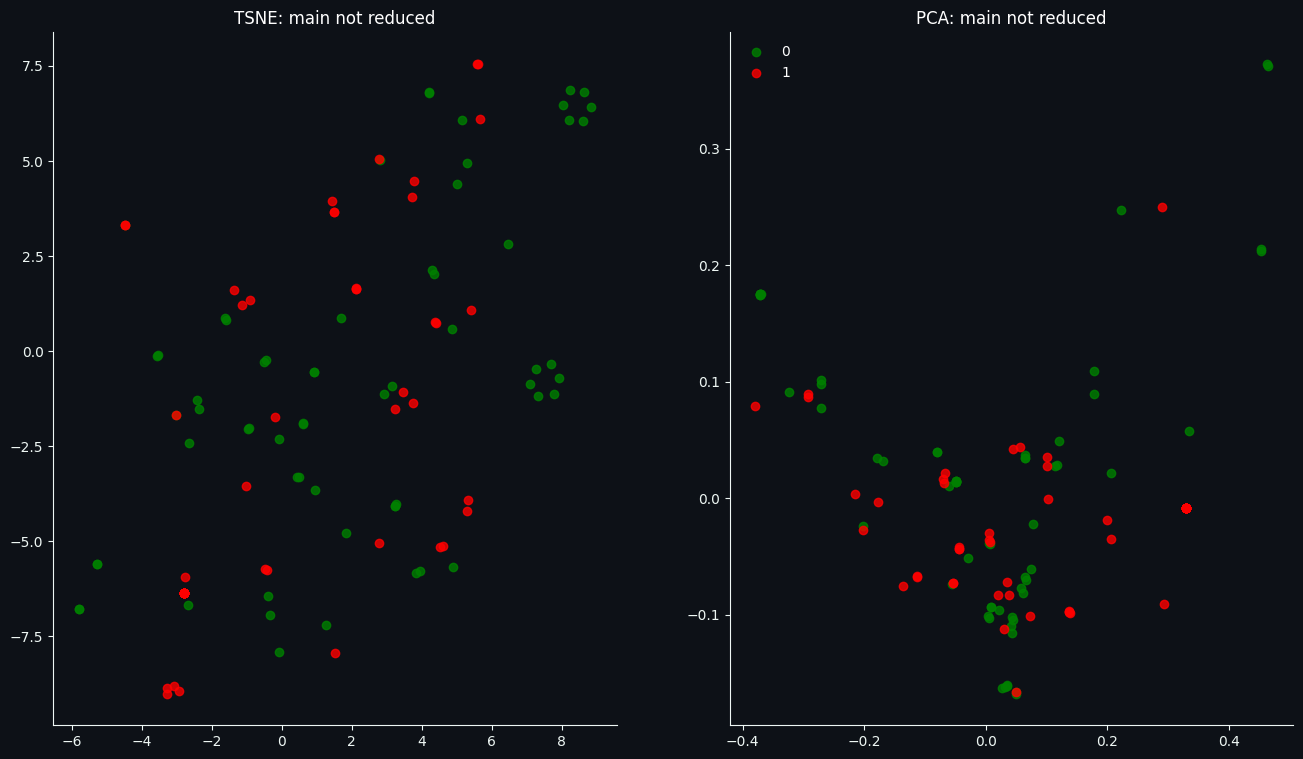

In [66]:
plot_2d(dataset.values, target, "main not reduced")

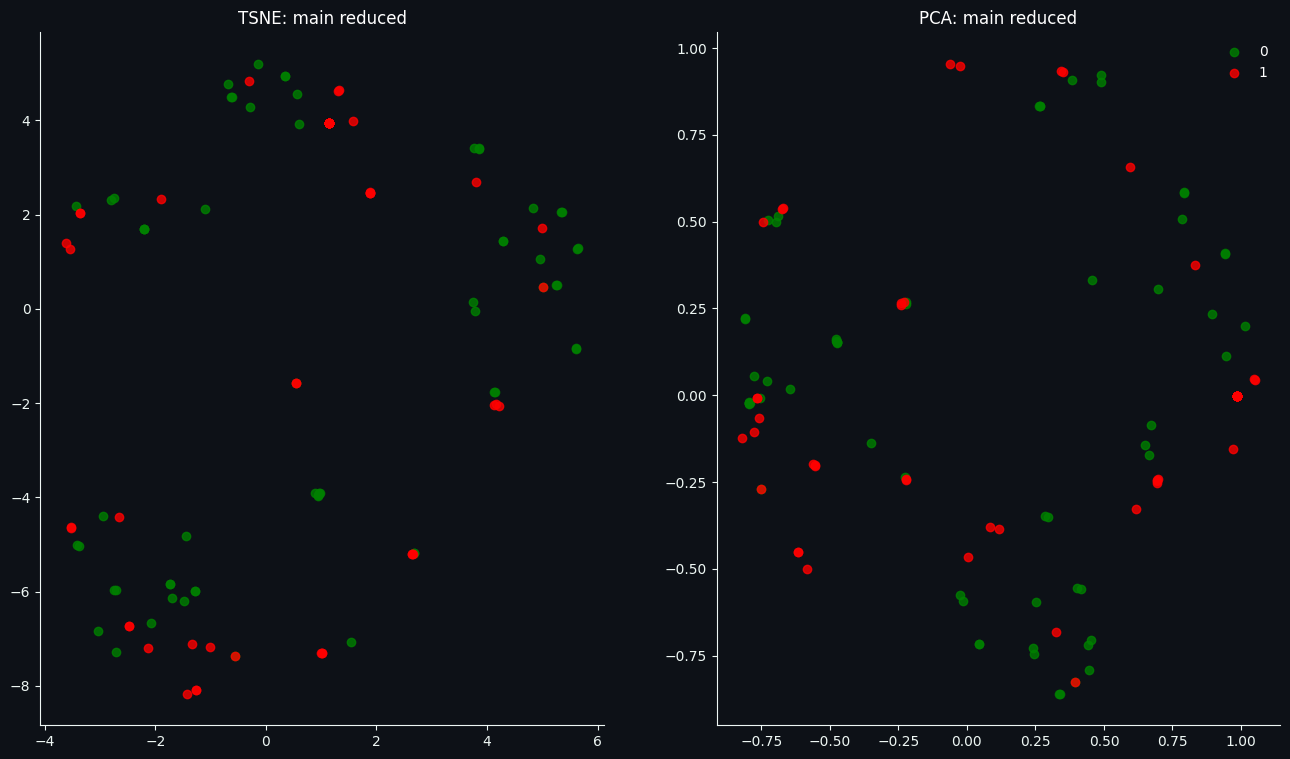

In [67]:
plot_2d(main_reduced, target, "main reduced")

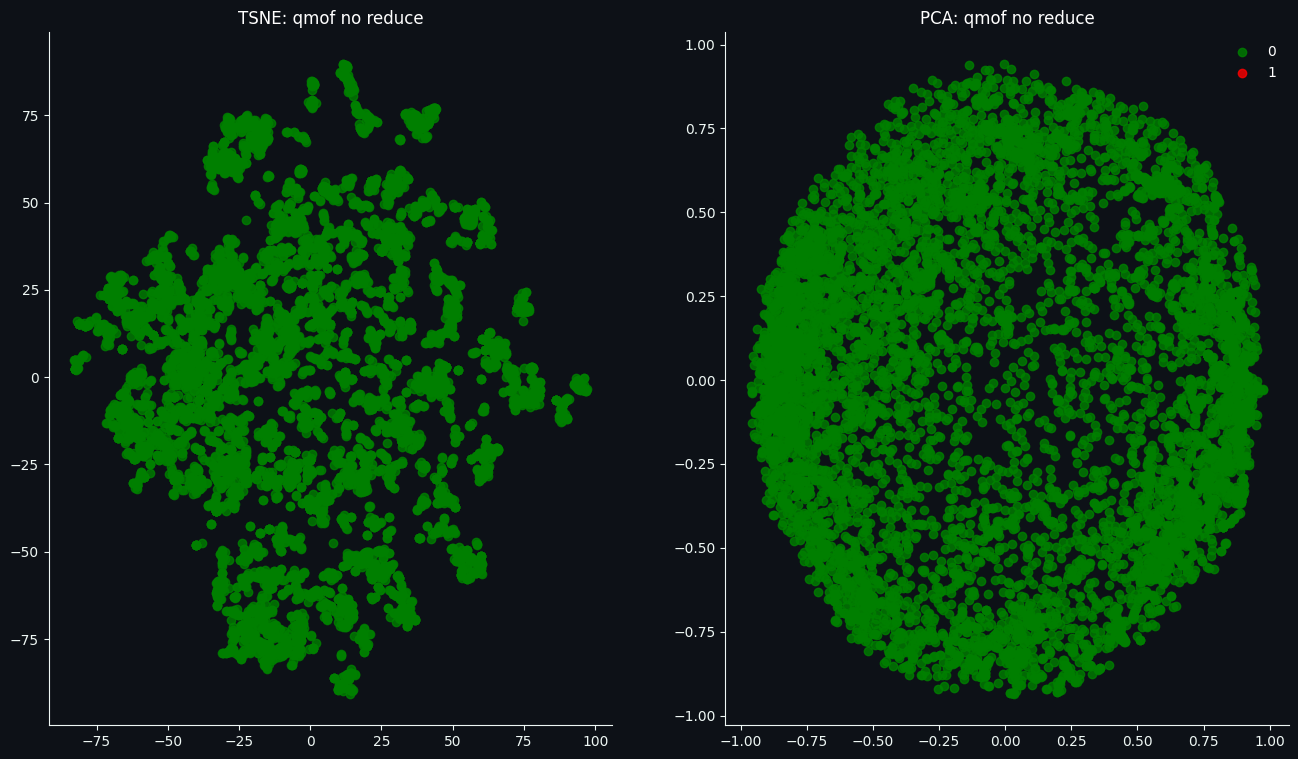

In [68]:
plot_2d(reduced, np.zeros((reduced.shape[0])), "qmof no reduce")

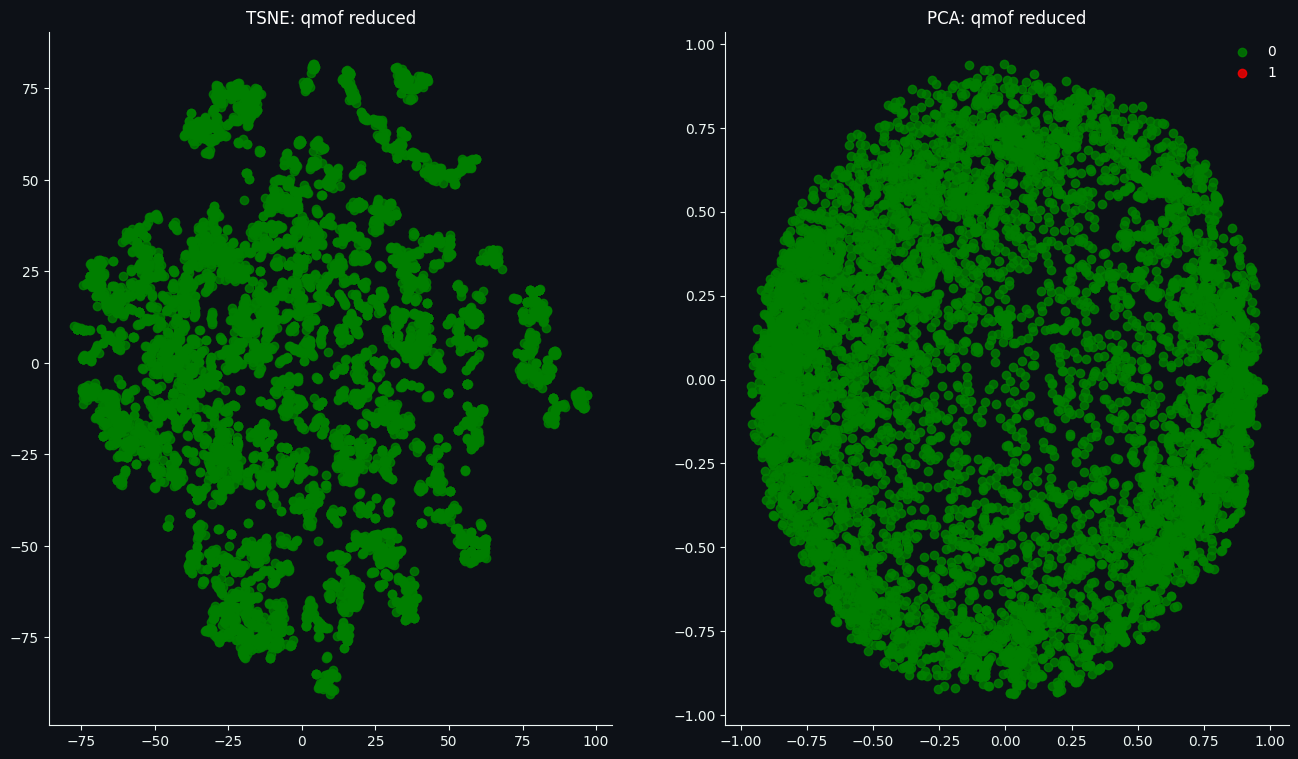

In [69]:
plot_2d(qmof_reduced, np.zeros((qmof_reduced.shape[0],)), "qmof reduced")

# Classification

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=42,
    stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qmof_reduced_scaled = scaler.transform(qmof_reduced)

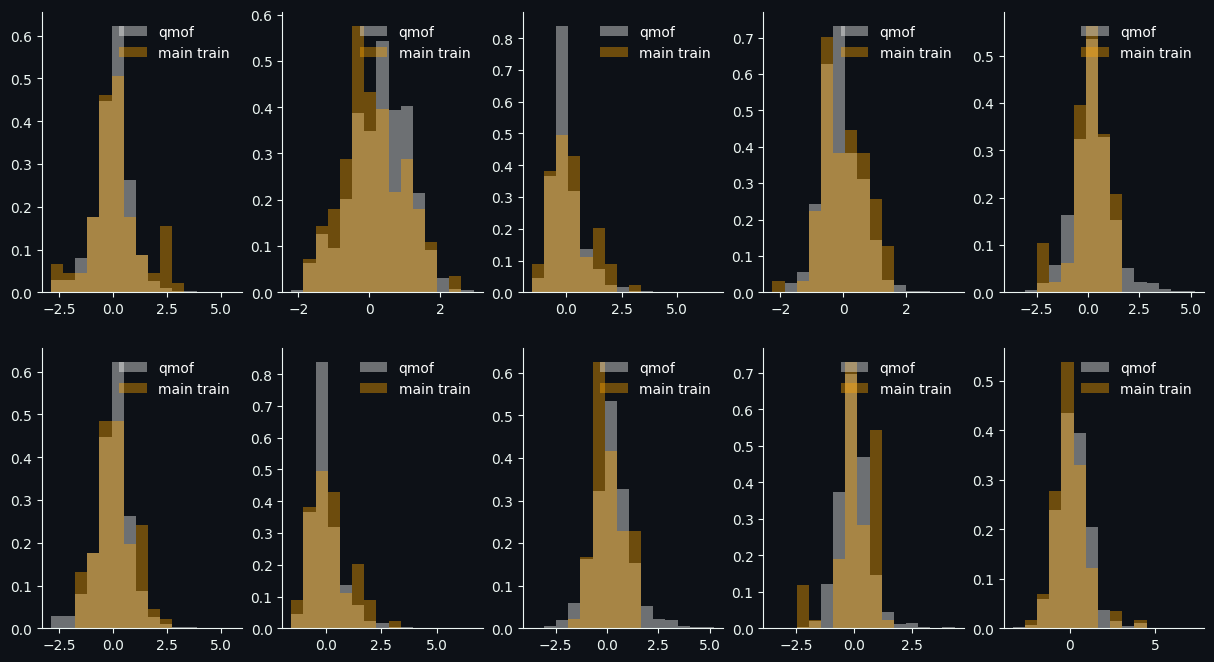

In [71]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))

for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced_scaled[:, j+i*j], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,j].hist(X_train[:, i+j], density=True, bins=bins, alpha=0.4, label="main train", color='orange')
        axes[i,j].legend()

In [72]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 32/9223372036854775807 [00:10<819420222285705:40:16,  3.13trial/s, best loss: -0.6685222672064776] 
best depth ber folds: [12, 10, 5, 8, 6]
best n_estimators ber folds: [58, 35, 59, 58, 55]
best learning_rate ber folds: [2.6609964058945205e-05, 0.0006770772625627153, 0.00014353374603069455, 0.0005648046129545904, 1.6703425093667077e-05]
best l2_leaf_reg ber folds: [0.1942346699058348, 0.17807891108912657, 0.2235331388932024, 0.3991832432097868, 0.05783768142816077]
evaluate RF
  0%|          | 73/9223372036854775807 [00:10<353550532785571:37:36,  7.25trial/s, best loss: -0.6685222672064776]
best max_depth ber folds: [17, 18, 15, 13, 11]
best n_estimators ber folds: [51, 88, 80, 50, 61]
evaluate AdaBoost
  0%|          | 80/9223372036854775807 [00:10<321598820796800:08:32,  7.97trial/s, best loss: -0.75]              
best max_depth ber folds: [10, 8, 4, 5, 9]
best n_estimators ber folds: [51, 47, 51, 52, 53]
best learning_rate ber folds: [0.0003349703803392942, 0.00027

In [73]:
res

{'CatBoost': {'depth': 5,
  'l2_leaf_reg': 0.2235331388932024,
  'learning_rate': 0.00014353374603069455,
  'n_estimators': 59,
  'score': 0.9253246753246753,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 39, '1.0': 26}}},
 'RF': {'max_depth': 17,
  'n_estimators': 51,
  'score': 0.8645276292335116,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}},
 'AdaBoost': {'learning_rate': 0.0009658450175168347,
  'max_depth': 5,
  'n_estimators': 52,
  'score': 0.8583333333333334,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 39, '1.0': 26}}},
 'Knn': {'n_neighbors': 3,
  'score': 0.7858637526156709,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}}}

In [74]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [75]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.79
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        13
         1.0       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

report for RF: 0.67
              precision    recall  f1-score   support

         0.0       0.88      0.54      0.67        13
         1.0       0.54      0.88      0.67         8

    accuracy                           0.67        21
   macro avg       0.71      0.71      0.67        21
weighted avg       0.75      0.67      0.67        21

report for AdaBoost: 0.71
              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73        13
         1.0       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
we

In [76]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

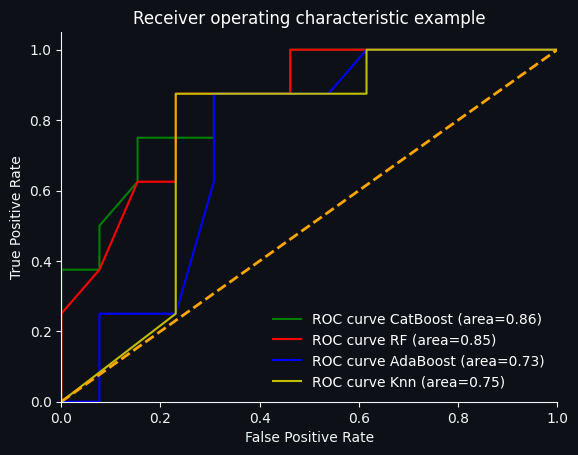

In [77]:
roc_auc_plot(c_model, X_test, y_test)

In [78]:
cat_ = reduced

In [79]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))
pca = PCA(n_components=2, random_state=0)
X_p = pca.fit_transform(scaler.transform(cat_))

In [80]:
xt_q = X_t[:qmof_reduced.shape[0]]
xp_q = X_p[:qmof_reduced.shape[0]]

xt_m = X_t[qmof_reduced.shape[0]:]
xp_m = X_p[qmof_reduced.shape[0]:]
pr_m = target.values.ravel()

In [81]:
pr_q = {name: c_model.models[name].predict_proba(qmof_reduced_scaled)[:,1] for name in c_model.models}

In [82]:
def colormap_plot(name):
    color = pr_q[name]

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))

    ax1.scatter(xt_q[:, 0], xt_q[:, 1], alpha=0.2, c=color, cmap="seismic")

    ax1.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', color='purple', s=50, label='no guest molecules (main)')
    ax1.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', color='orange', s=50, label='guest molecules (main)')


    ax1.set_title(f"TSNE representation of predicted probability for {name}")
    map = ax2.scatter(xp_q[:, 0], xp_q[:, 1], marker='o', c=color, alpha=0.2, cmap='seismic')
    


    ax2.scatter(xp_m[pr_m == 0, 0], xp_m[pr_m == 0, 1], marker='v', color='purple', s=50, label='no guest molecules (main)')
    ax2.scatter(xp_m[pr_m == 1, 0], xp_m[pr_m == 1, 1], marker='v', color='orange', s=50,label='guest molecules (main)')

    ax2.set_title(f"PCA representation of predicted probability for {name}")
    ax2.legend()
    figure.colorbar(map)


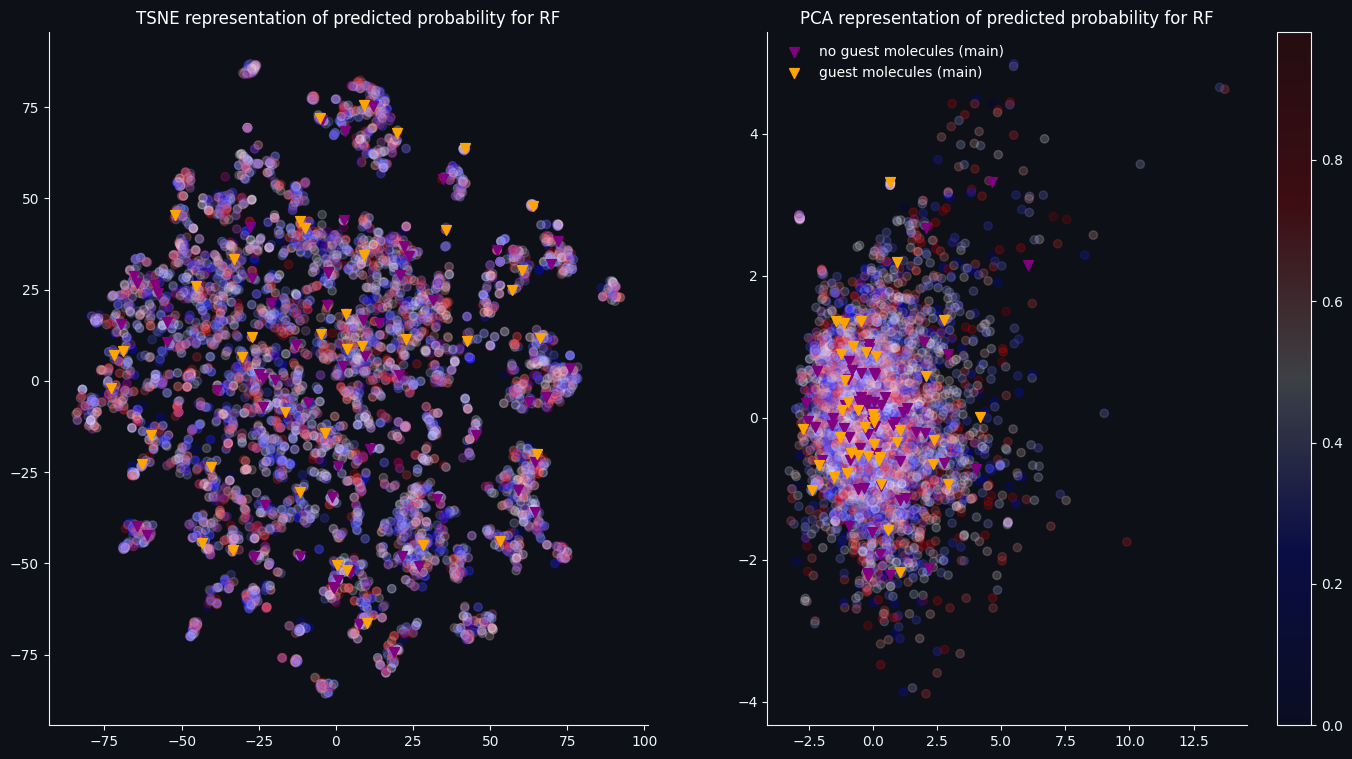

In [83]:
colormap_plot("RF")

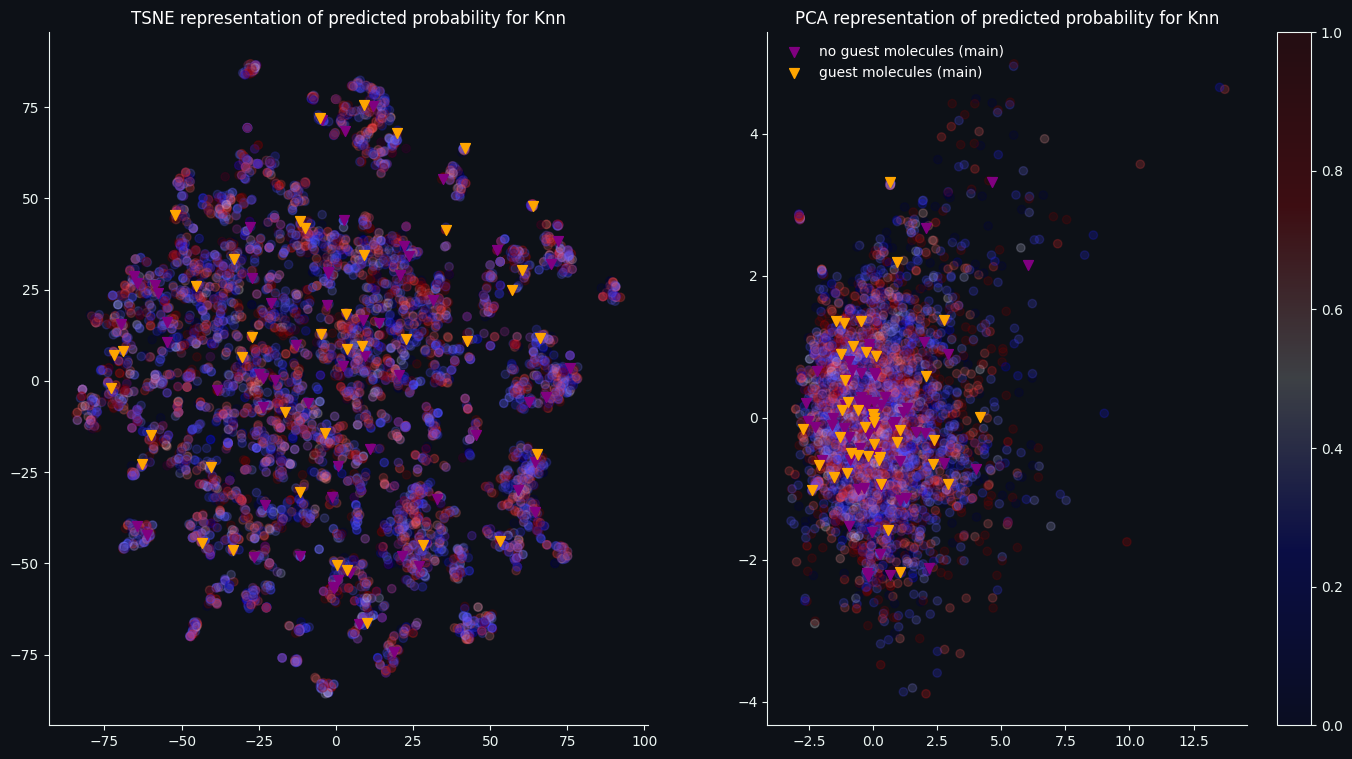

In [84]:
colormap_plot("Knn")

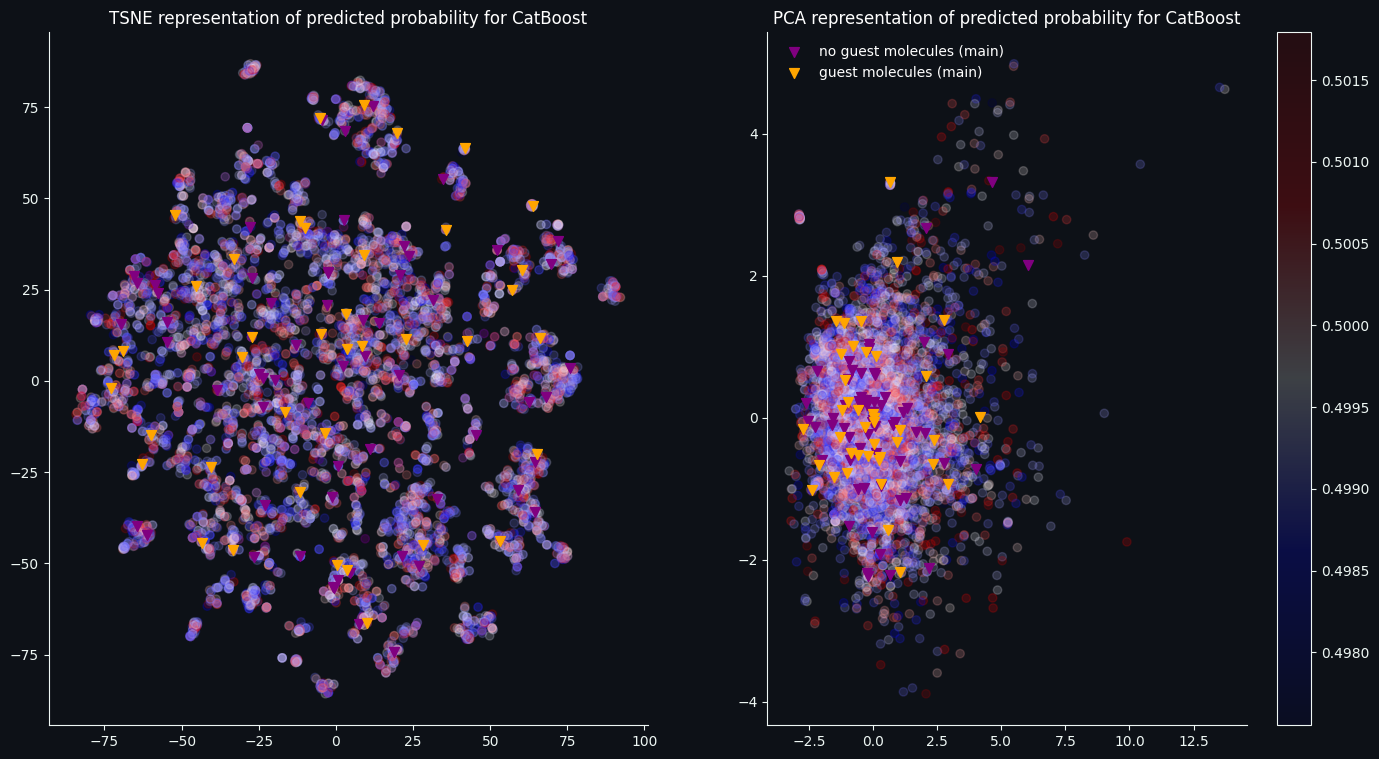

In [85]:
colormap_plot("CatBoost")

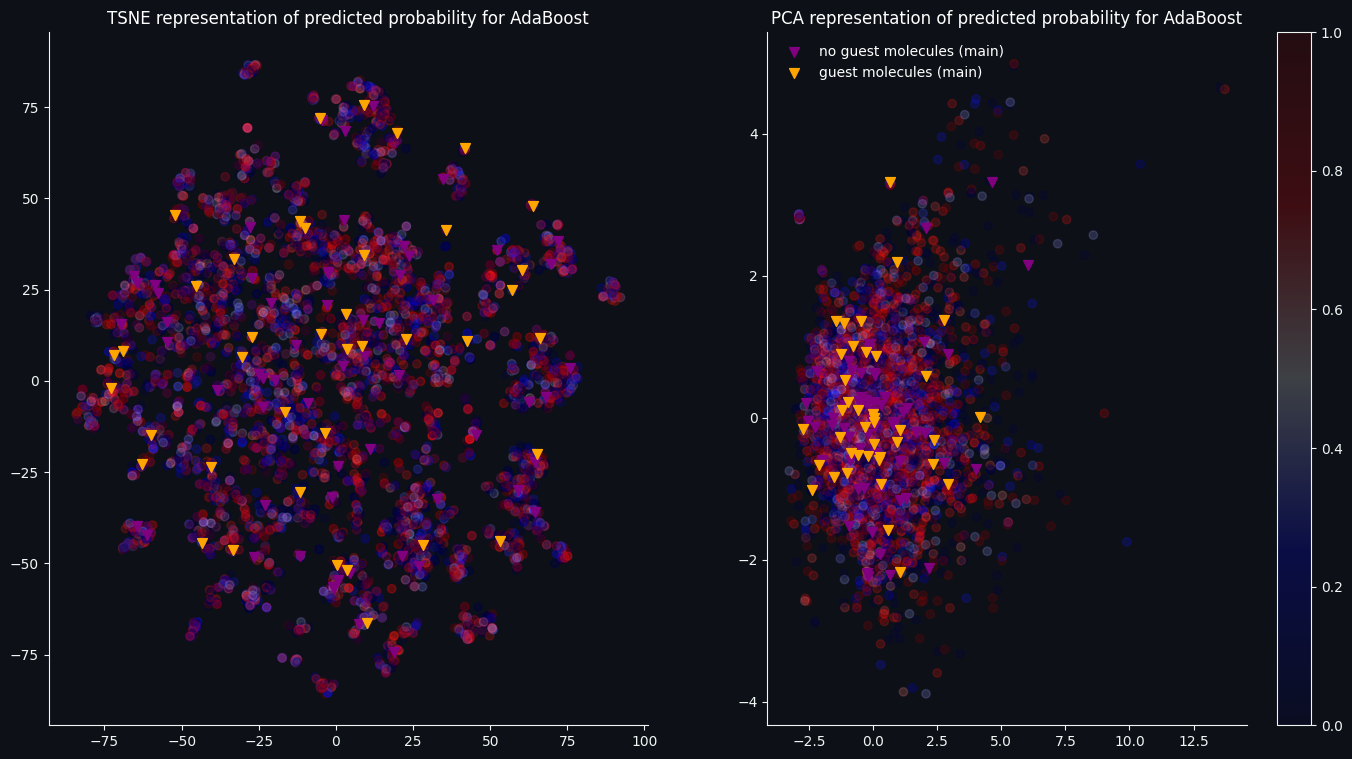

In [86]:
colormap_plot("AdaBoost")

In [87]:
# import joblib

# joblib.dump(reduce_model, "best/reduce_model.pkl")

# joblib.dump(c_model, "best/c_model.pkl")

# joblib.dump(res, "best/best_params.pkl")
